# COGS 108 - Final Project 

# Overview

This project set out to explore the difference between Yelp reviewer's expectations for restaraunt's health standards in relation to the median household income of the restaraunt. In particular, we suspected that in lower income areas, Yelp reviewer's Yelp rating would be less influenced by the health inspection score the restaraunt received, than in higher income areas.

These suspicions proved untrue when we examined the restaraunts in the top and bottom 25% of median household incomes, but showed they may have some validty when taking the top and bottom 1%.

The restaraunts analyzed all came from the state of North Carolina.

# Name & PID

- Name: Justin Gross
- PID: A15753144

# Research Question

Do Yelp reviewers for restaraunts in higher income communities have higher expectations for the health standards of those restaraunts than Yelp reviwers reviewing restaraunts in lower income areas? That is, are the health inspection scores more dependent on yelp ratings in higher income areas than in lower income areas.

## Background and Prior Work

There has been work done to answer questions such as whether or not Yelp reviews and health inspection violations are related (ref 1). In this study, they found that Yelp reviews and health violations were only correlated in chain food facilitis. These findings are interesting, but do not answer our questions of whether we can stratify restraunts by their community's income to achieve different results. However, if we find there is not much correlation between Yelp rating and health inspection score (since this is dependent on violations), our results would be in agreement. Also worth noting is that these results are from one city—New York City.

Another interesting study from our own UCSD has done work on developing models to predict hygine conditions through Yelp reviews (ref 2). This is interesting in the context of my project because their model—which levearges Yelp scores—does offer some improvments on finding restaraunts with health violations. This suggests that we may be able to find some correlation between the two. If this project also finds correlation between the health inspection ratings and Yelp reviews, it will be interesting to find out if this relationship is stronger in low or high income communities.

References (include links):
- 1) https://www.jstor.org/stable/26330473?seq=1
- 2) http://jmcauley.ucsd.edu/cse258/projects/fa15/036.pdf

As discussed in the review of some background work, this project hopes to go a step deeper and examine if there is a higher "tolarance" of Yelp reviewers, reviewing restaraunts in lower income areas, for restaraunts with lower health inspection scores.

# Hypothesis


I hypothesize that Yelp reviews for restaraunts in lower income communities are less correlated with health inspection scores than Yelp reviews for restaraunts not in lower income communities. More specifically, I hypothesize that restaraunts with high Yelp ratings, but low(er) health inspection scores, are more likely to exist in low income areas than in high income areas.


The intuition for this hypothesis is simply based on sterotypes of higher income communities. In particular that higher income households may tend to be more picky and less tolerant of establishments that do not meet their higher standards.

# Datasets

The datasets used for this project are as follows:

- Dataset Name: Yelp.csv
- Link to the dataset: Provided
- Number of observations: 3688


- Description: Yelp statistics for different restaraunts. Key features this project will take advantage of are the average Yelp rating and zip code.


- Dataset Name: Inspections.csv
- Link to the dataset: Provided
- Number of observations: 18466


- Description: Health inspection scores for different restaraunts. Key features this project will take advantage of are the inspection score and the zip code.


- Dataset Name: Zipcodes.csv
- Link to the dataset: Provided
- Number of observations: 38

- Description: Several metrics describing the income for each zip code. This project will be using median household income from this dataset.


The Yelp and Inspections datasets will be combined by inner merging both on address and phone numbers. We must inner merge on both, because the many restaraunts in the dataset share the same address—perhaps because it's a shared plaza or building—but none share the same address and the same phone number. Next, we will inner merge on the zip code, so that we have income information for each restaraunt.

Finally, I must make clear that all datasets used come from data gathered soley from the state of North Carolina. Though I would hope that the results of this analysis are consistent with other areas as well, this assumption cannot be made.

# Setup

In [1]:
import numpy as np
import pandas as pd
import patsy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Import the datasets into pandas dataframes
df_yelp = pd.read_csv('./data/yelp.csv')
df_inspections = pd.read_csv('./data/inspections.csv')
df_zipcodes = pd.read_csv('./data/zipcodes.csv')


# Data Cleaning

For data cleaning, we will narrow our data frames down to only the necessary fields, standardize the column names, and combine the data into a single data frame.

There are a few important things we must do to clean the data including:
* Standardizing the phone numbers
  * Inspections uses the format (808) 123-4567
  * Yelp uses the format 18081234567
* Standardizing the addresses
  * The capitilization of the addresses is inconsistent. To solve this, we simply convert the address strings to all lowercase
* The column names were renamed to follow a consistent, and easier to understand format
* Rows that did not contain an address were removed from the dataset. An N/A entry for the address should not have any relation to its health inspection score, so this is acceptable.
* Finally, all the columns we do not need to answer our research question have been droppped

In [2]:
# Remove unused yelp fields and rename columns
df_yelp = df_yelp[['zip_code', 'rating', 'phone', 'address1']]
df_yelp = df_yelp.rename({"zip_code": "zip", "rating":"yelp_rating"}, axis='columns')

# Remove unused inspection fields and rename columns
df_inspections = df_inspections[['zip', 'score', 'phonenumber', 'address1']]
df_inspections = df_inspections.rename({"score":"inspection_score", 'phonenumber': 'phone'}, axis='columns')

# Remove unused zipcode fields and rename columns
df_zipcodes = df_zipcodes[['zip', 'median_household_income_dollars']]
df_zipcodes = df_zipcodes.rename({"median_household_income_dollars":"income"}, axis='columns')


In [3]:
# Change the phone numbers in the inspections dataframe to match the format of the yelp data frame
def standardize_phone(s):
    # If s is not a string, return None
    if not isinstance(s, str):
        return None
    
    # Remove extensions
    if 'ext' in s:
        s = s[:s.find('ext')].strip()
    
    res = "1"
    for c in s:
        if c.isnumeric():
            res += c
            
    return res

assert(standardize_phone("(919) 792-0333") == "19197920333")


In [4]:
# Apply the standardized phone number
df_inspections['phone'] = df_inspections['phone'].apply(standardize_phone)


In [5]:
# Also put the addresses into all lowercase form
df_inspections = df_inspections.dropna(subset=['address1'])
df_yelp = df_yelp.dropna(subset=['address1'])

df_inspections['address1'] = df_inspections['address1'].apply(lambda x : x.lower())
df_yelp['address1'] = df_yelp['address1'].apply(lambda x: x.lower())


In [6]:
# Merge the dataframes together
# print(df_inspections.head())
# print(df_inspections['phone'].value_counts())

# We have to merge by phone number because that's the only consistent unique thing.
df = df_yelp.merge(df_inspections, on=['phone', 'address1'], how='inner')

# Remove duplicate columns
df = df.drop(['zip_y'], axis=1)
df = df.rename({'zip_x': 'zip'}, axis='columns')

# Merge in the zipcode income information
df = df.merge(df_zipcodes, on='zip', how="inner")


# Data Analysis & Results

The first step of our analysis will be to separate the zip codes into two classes:

1. Lower income, which we will define restaraunts in zip codes that have the bottom 25% of median household income
1. Higher income, which we will define restaraunts in zip codes that have the top 25% of median household income

Once we have this, we can begin exploratory analysis to see if we can observe any obvious differences between the two groups.

In [7]:
# We are going to take the top 25% and bottom 25%
obs_size = int(len(df) * .25)

df_lower = df.nsmallest(n=obs_size, columns='income')
df_higher = df.nlargest(n=obs_size, columns='income')


To start, lets examine the distributions of Yelp scores for the two groups.

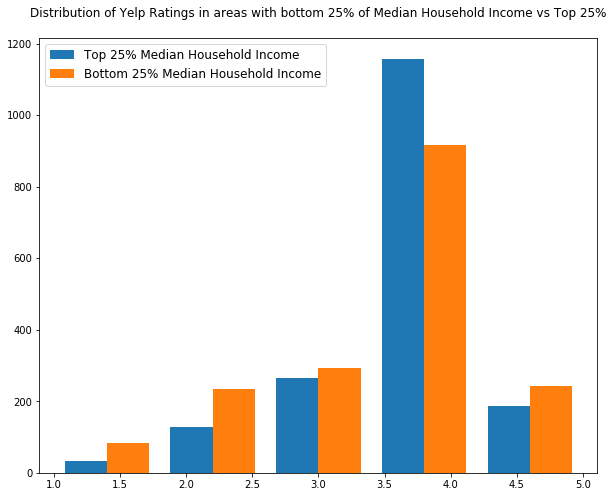

In [8]:
plt.figure(figsize=(10, 8))

labels = ["Top 25% Median Household Income", "Bottom 25% Median Household Income"]
ax = plt.hist((df_higher['yelp_rating'], df_lower['yelp_rating']), bins=5, label=labels)

plt.legend(loc="upper left", fontsize='large')
plt.title("Distribution of Yelp Ratings in areas with bottom 25% of Median Household Income vs Top 25%\n")
plt.show()


It appears that there is a definite bias in both groups towards the upper middle ratings in the 3.5-4 range. Interestingly though, lower income areas seem slightly more likely to give both lower and the highest ratings. Higher income areas on the other hand seem more likely to default to the 3.5-4 range. This could signal several things. For example, perhaps high income restraunts are just less likley to be so bad they warrant a 1-2.5 Yelp rating.


But we can't jump to conclusions. Lets now examine the distribution of health inspection scores.

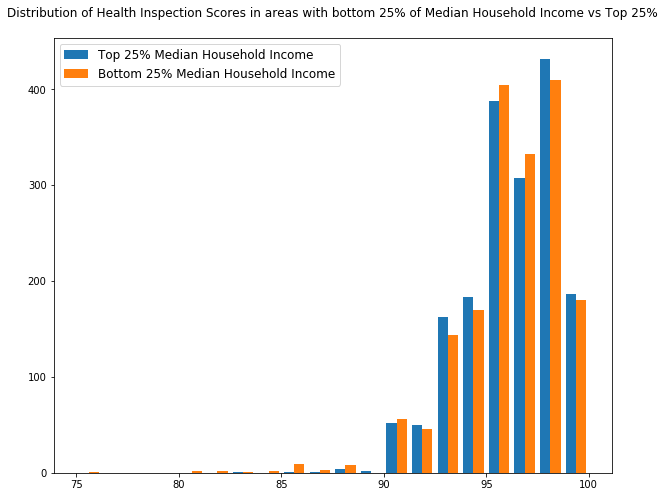

In [9]:
plt.figure(figsize=(10, 8))

labels = ["Top 25% Median Household Income", "Bottom 25% Median Household Income"]
ax = plt.hist((df_higher['inspection_score'], df_lower['inspection_score']), bins=20, label=labels)

plt.legend(loc="upper left", fontsize='large')
plt.title("Distribution of Health Inspection Scores in areas with bottom 25% of Median Household Income vs Top 25%\n")
plt.show()


From this plot we see that there is slightly more restaraunts with the highest health inspection ratings in the higher income area. For the most part though, the inspection scores tend to be fairly good. Slightly more lower income areas do particularly bad in the health inspeciton score areas, but there are still some high income restaraunts that do badly too.

Additionally, we discovered an outlier around the 75 inspection score. We will remove this observation as it could skew our results.

In [10]:
# Confirm the outlier value
assert(df_lower['inspection_score'].value_counts()[75.0] == 1)

df_lower = df_lower[df_lower['inspection_score'] > 75]

# Confirm the outlier value is gone
assert(all(df_lower['inspection_score'] > 75))


The main analysis will be determining the relationships between the Yelp ratings and health inspection scores, and how those two differ for each income area. However, lets get a quick feel for what our results may yield with a nifty kernel density plot. This will show us how common the Yelp scores are for each health inspection score.

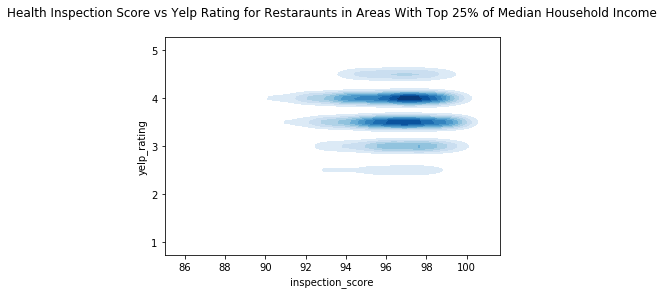

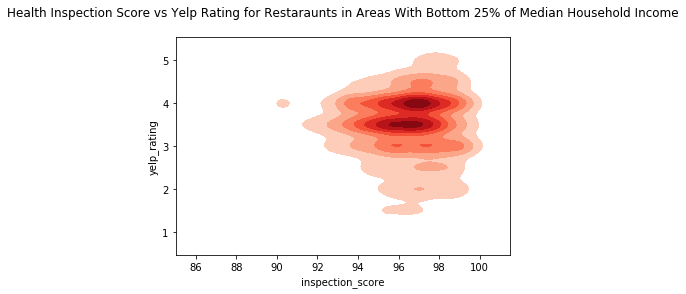

In [11]:
plt.clf()
g2 = sns.kdeplot(df_higher['inspection_score'], df_higher['yelp_rating'],
                 cmap="Blues", shade=True, shade_lowest=False, clip=((85,110),(0,6)))
plt.title("Health Inspection Score vs Yelp Rating for Restaraunts in Areas With Top 25% of Median Household Income\n")
plt.show(g2)

plt.clf()
# plt.figure()
plt.title("Health Inspection Score vs Yelp Rating for Restaraunts in Areas With Bottom 25% of Median Household Income\n")
g1 = sns.kdeplot(df_lower['inspection_score'], df_lower['yelp_rating'],
                 cmap="Reds", shade=True, shade_lowest=False, clip=((85,110),(0,6)))
plt.show(g1)


As we can see, for higher income areas, the Yelp ratings vs health inspection ratings seem a bit more narrow. On the other hand, the lower income areas have more range for how the two scores are related.


Now that we have done our exploratory data analysis, lets get get into answering the real question!

A quick reminder, we are trying to determine if Yelp ratings in lower income communities are less likely to signal a lower health inspection score.

To determine this relationship I chose to use an Ordinary Least Squares model as I expect from our exploratory analysis that there could be a linear relationship between yelp ratings and inspection scores.


In [12]:
# Analysis for top 25% income
outcome_2, predictors_2 = patsy.dmatrices('inspection_score ~ yelp_rating', df_higher)
mod_2 = sm.OLS(outcome_2, predictors_2)
res_2 = mod_2.fit()
print(res_2.summary())


                            OLS Regression Results                            
Dep. Variable:       inspection_score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                  0.009276
Date:                Wed, 10 Jun 2020   Prob (F-statistic):              0.923
Time:                        15:28:26   Log-Likelihood:                -3987.5
No. Observations:                1771   AIC:                             7979.
Df Residuals:                    1769   BIC:                             7990.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      96.0437      0.308    312.251      

In [13]:
# Analysis for bottom 25% income
outcome_1, predictors_1 = patsy.dmatrices('inspection_score ~ yelp_rating', df_lower)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())



                            OLS Regression Results                            
Dep. Variable:       inspection_score   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.01038
Date:                Wed, 10 Jun 2020   Prob (F-statistic):              0.919
Time:                        15:28:26   Log-Likelihood:                -4158.0
No. Observations:                1770   AIC:                             8320.
Df Residuals:                    1768   BIC:                             8331.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      96.0005      0.254    378.337      

Unfortunately, neither the higher nor the lower income areas had Yelp ratings that were a significant predictor of the outcome variable—health inspection scores. Although it does appear that the Yelp ratings in the higher income areas are more impactful than in the lower income areas, it is not significant enough to conclude that our hypothesis was correct.

Before we give up though, lets try one more thing... Lets examine the 1%!


In [14]:
obs_size = int(len(df) * .01)

df_lower = df.nsmallest(n=obs_size, columns='income')
df_higher = df.nlargest(n=obs_size, columns='income')

# Remove that one outlier
df_lower = df_lower[df_lower['inspection_score'] > 75]



Lets quickly visualize the data for the top and bottom 1% income areas


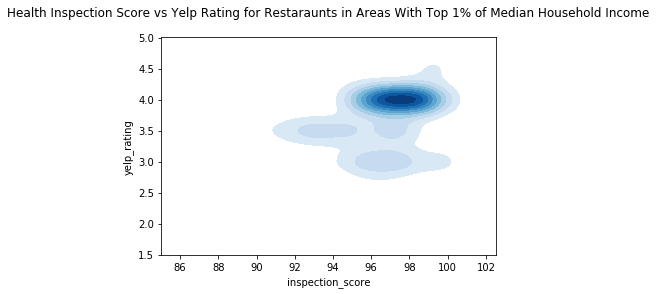

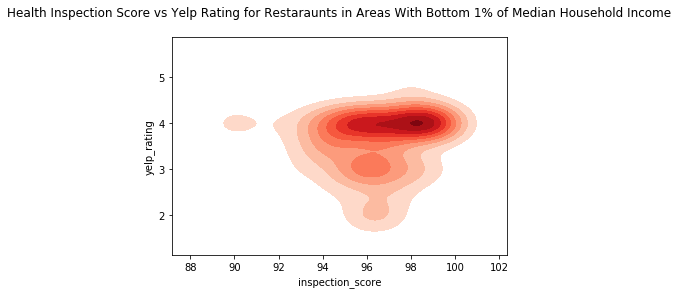

In [15]:
plt.clf()
g2 = sns.kdeplot(df_higher['inspection_score'], df_higher['yelp_rating'],
                 cmap="Blues", shade=True, shade_lowest=False, clip=((85,110),(0,6)))
plt.title("Health Inspection Score vs Yelp Rating for Restaraunts in Areas With Top 1% of Median Household Income\n")
plt.show(g2)

plt.clf()
# plt.figure()
plt.title("Health Inspection Score vs Yelp Rating for Restaraunts in Areas With Bottom 1% of Median Household Income\n")
g1 = sns.kdeplot(df_lower['inspection_score'], df_lower['yelp_rating'],
                 cmap="Reds", shade=True, shade_lowest=False, clip=((85,110),(0,6)))
plt.show(g1)

Interestingly—just from observing the graphs—it appears the highest income area is less bothered by health inspection scores as there are high density of high ratings within a large range of inspection scores. The lower income area actually seems to have the highest yelp ratings more closely matching the highest inspection scores.

Again though, we can't determine if this observation is significant just from the graphs. Lets again run our ordinary least squares analysis

Finally, we can carry out our analysis on these two groups

In [16]:
# Analysis for top 1% income
outcome_2, predictors_2 = patsy.dmatrices('inspection_score ~ yelp_rating', df_higher)
mod_2 = sm.OLS(outcome_2, predictors_2)
res_2 = mod_2.fit()
print(res_2.summary())


                            OLS Regression Results                            
Dep. Variable:       inspection_score   R-squared:                       0.147
Model:                            OLS   Adj. R-squared:                  0.134
Method:                 Least Squares   F-statistic:                     11.70
Date:                Wed, 10 Jun 2020   Prob (F-statistic):            0.00106
Time:                        15:28:27   Log-Likelihood:                -161.30
No. Observations:                  70   AIC:                             326.6
Df Residuals:                      68   BIC:                             331.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      89.0233      2.154     41.337      

In [17]:
# Analysis for bottom 1%
outcome_5, predictors_5 = patsy.dmatrices('inspection_score ~ yelp_rating', df_lower)
mod_5 = sm.OLS(outcome_5, predictors_5)
res_5 = mod_5.fit()
print(res_5.summary())


                            OLS Regression Results                            
Dep. Variable:       inspection_score   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.6595
Date:                Wed, 10 Jun 2020   Prob (F-statistic):              0.420
Time:                        15:28:27   Log-Likelihood:                -149.92
No. Observations:                  70   AIC:                             303.8
Df Residuals:                      68   BIC:                             308.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      95.2053      1.449     65.712      

Wow! Now we see some interesting results! At first glance, the yelp_rating's coefficient of nearly 2 for the top 1% of income areas signals that the highest income areas are indeed more sensitive to health inspection scores than the lowest 1% of income areas, whose yelp_rating only had a coefficient of 0.32. 

However, if we look at the distribution of health inspection scores for these income brackets, the average inspection score is actually quite a bit higher in the lowest income areas.


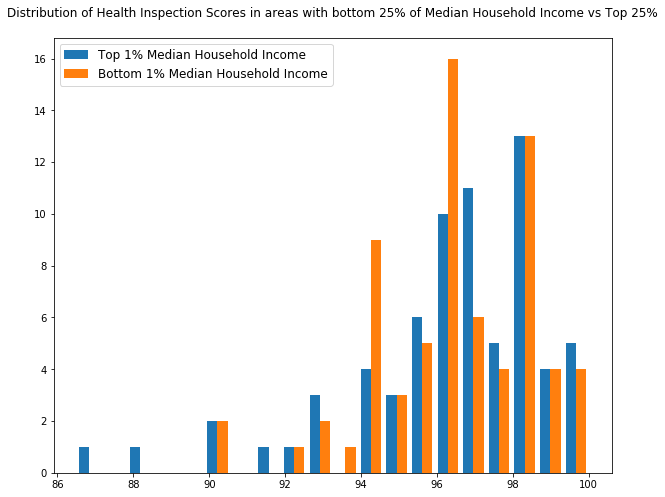

In [18]:
plt.figure(figsize=(10, 8))

labels = ["Top 1% Median Household Income", "Bottom 1% Median Household Income"]
ax = plt.hist((df_higher['inspection_score'], df_lower['inspection_score']), bins=20, label=labels)

plt.legend(loc="upper left", fontsize='large')
plt.title("Distribution of Health Inspection Scores in areas with bottom 25% of Median Household Income vs Top 25%\n")
plt.show()

Additionally, the two outliers in the highest income areas have lower yelp ratings (as shown below). So perhaps, those outliers contribute to the higher Yelp rating contribution in our analysis.

In [19]:
df_higher[df_higher['inspection_score'] < 90]['yelp_rating']

2508    3.0
2510    2.0
Name: yelp_rating, dtype: float64

Let's remove those two outliers and try again

In [20]:
# Analysis for top 1% income
df_higher = df_higher[df_higher['inspection_score'] >= 90]
outcome_2, predictors_2 = patsy.dmatrices('inspection_score ~ yelp_rating', df_higher)
mod_2 = sm.OLS(outcome_2, predictors_2)
res_2 = mod_2.fit()
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:       inspection_score   R-squared:                       0.039
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     2.676
Date:                Wed, 10 Jun 2020   Prob (F-statistic):              0.107
Time:                        15:28:28   Log-Likelihood:                -147.78
No. Observations:                  68   AIC:                             299.6
Df Residuals:                      66   BIC:                             304.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      93.1608      2.107     44.214      

Even after removing those two, the impact of Yelp rating in the highest income areas is still quite a bit higher than it is in the lowest income areas of North Carolina.

For the top 1% and bottom 1% of median household income for zip codes in North Carolina, this difference may be significant enough to reject the null hypothesis that there is no difference between the relationship between Yelp ratings and health inspections for restaraunts within the income two groups. But, we will summarize and discuss these results in more detail in the conclusion.


# Ethics & Privacy

Before carrying out this project and the analysis I had several major concerns about the possible repercussions it could have. The major considerations include the following points:


* The personal information and identifying features of the health inspectors giving the health inspection scores, as well as the Yelp reviewers rating the restaraunts should be strictly private.


* The results of the analysis could cause readers to walk away with unfair biases towards certain groups. For example, if the lower income communities had Yelp ratings that depended significantly less on health inspection ratings, some might draw the incorrect conclusion that this is because the people in lower income areas are slobs.


* We must acknowledge where the data was gathered and make clear that it may not be representative of the larger population.


To address these issues identified, I will take the following precautions:

First, the personal information of all the health inspectors will be removed. Furthermore, the zip codes, addresses, restaraunt names, phone numbers, and any other identifying information will not be shown in the analysis. The only data that shall be visible to the reader in the analysis will be the Yelp ratings, Inspection scores, and an income percentile for the state of North Carolina. These things are all available to the public already.

Next, to avoid unfair biases towards lower and higher income groups, this analysis will take a very objective, data driven approach. Furthermore, our conclusion will make clear all the other factors that could possibly be driving the results we end up with.

Finally, we must make it clear that the data used in this analysis is solely from the state of North Carolina. This will be mentioned in the dataset section, and again here. Therefore, we will make it clear to the reader that these result may not necessarily genrealize to the rest of the population, as they are not at all a random sample.



# Conclusion & Discussion

During our analysis we found some interesting results. We started off by taking two groups from the restaraunt population of North Carolina: Restaraunts located in zip codes that are in the top 25% of median household income, and then the bottom 25% of that same criteria.

Within these two groups, we attempted to answer the question of whether the lower income group's Yelp ratings would be less informative of how high the health inspection scores were. For the top and bottom 25% percent of incomes, we found no significant difference in the relationship between health inspection scores and Yelp ratings.

However, when we repeated the experiment with the top and bottom 1% of income areas, we found that our hypothesis fit much better. Indeed, the health inspection scores in the higher income group were significantly more sensitive to the restaraunts Yelp ratings. This indicates that people reviewing restaraunts in the highest income groups are more sensitive to health inspection scores than those people reviewing restaraunts in the lowest income areas.

However, taken out of context, this statement is more provactive than it should be. To end this discussion I want to make clear that the actual significance of these findings is honestly quite low. In the analysis that found that the top 1% restaraunt reviewers were more sensitive to health inspection score, all restaraunts in that data had a health inspection score of above 90. Even in the lower income areas. Therefore, it is important to note that these facilities all had an A rating, so it can absolutely not be concluded that one income group has low health standards, or anything of the sort.

Lastly, I want to note that the sample size for the top and bottom 1% income areas were only about 70 restaraunts per income group. Therefore, with a larger sample size, it is possible we may see different results.

Due to the limitations of our data discussed above and throughout this project, we cannot reject or accept our initial hypothesis. Though, we have definitely made some interesting observations that could inform further analysis.
